# Speech Emotion Recognition

**Importing Libraries**

In [1]:
import IPython
import librosa
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
from PIL import Image
import random
import seaborn as sns
import scipy.io

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv1D, MaxPooling1D, Flatten, BatchNormalization
from keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Reshape
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import LSTM
from keras_self_attention import SeqSelfAttention

%matplotlib inline

**Utility Functions**

In [2]:
def find_min_list_len(list_of_lists):
    return np.min([len(i) for i in list_of_lists])

In [3]:
def find_max_list_len(list_of_lists):
    return np.max([len(i) for i in list_of_lists])

In [4]:
def return_random_audio_sample(df, label):
    return df.query(f"label == {label}").sample(n=1).index[0]

In [9]:
ased_path = Path('C:/Users/Admin/Documents/GitHub/msba265-finalstorage/Models/Audio/speech emotion model/Model testing/data/ASED')
label_map = {
    'a': 'anger',
    'f': 'fear',
    'h': 'happy',
    'n': 'neutral',
    's': 'sadness'
}
X = list(ased_path.glob(r'**/*.wav'))
y = [label_map[file[0].lower()] for file in os.listdir(ased_path) if file.endswith('.wav')]

In [ ]:
df = pd.DataFrame({'path': X, 'label': y})
df

,path,label
0,C:\Users\Admin\Documents\GitHub\msba265-finals...,anger
1,C:\Users\Admin\Documents\GitHub\msba265-finals...,anger
2,C:\Users\Admin\Documents\GitHub\msba265-finals...,anger
3,C:\Users\Admin\Documents\GitHub\msba265-finals...,anger
4,C:\Users\Admin\Documents\GitHub\msba265-finals...,anger
...,...,...
2469,C:\Users\Admin\Documents\GitHub\msba265-finals...,sadness
2470,C:\Users\Admin\Documents\GitHub\msba265-finals...,sadness
2471,C:\Users\Admin\Documents\GitHub\msba265-finals...,sadness
2472,C:\Users\Admin\Documents\GitHub\msba265-finals...,sadness


In [11]:
set(y)

{'anger', 'fear', 'happy', 'neutral', 'sadness'}

In [12]:
df['label'].value_counts()

label
neutral    522
fear       510
anger      486
happy      486
sadness    470
Name: count, dtype: int64

**Sample for Anger**

In [13]:
IPython.display.Audio(df['path'][0])

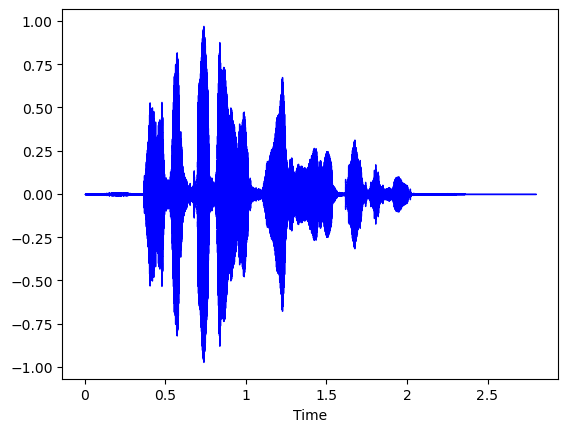

In [14]:
anger_sample = librosa.load(df['path'][0])[0]
librosa.display.waveshow(anger_sample, color="blue")

### Preparing Dataset

**Loading Audio into DataFrame**

In [15]:
X = []
audio_sampling = []
length = []
audio_arrays = []

for i in df['path']:
    x, sr = librosa.load(i, sr=44100)
    X.append(x)
    audio_sampling.append(sr)
    length.append(len(x))
    audio_arrays.append(x)
    
X = np.array(X, dtype='object')

**Transforming Labels**

In [16]:
le = LabelEncoder()
y = utils.to_categorical(le.fit_transform(y))
y

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

In [17]:
le_name_mapping = dict(zip(le.classes_, utils.to_categorical(le.transform(le.classes_))))
le_name_mapping

{'anger': array([1., 0., 0., 0., 0.]),
 'fear': array([0., 1., 0., 0., 0.]),
 'happy': array([0., 0., 1., 0., 0.]),
 'neutral': array([0., 0., 0., 1., 0.]),
 'sadness': array([0., 0., 0., 0., 1.])}

**Splitting into training, validation and test sets**

In [18]:
_, _, _, _, indices_train_val, indices_test = train_test_split(X, y, np.arange(len(X)), test_size=0.3, random_state=42, stratify=y)
_, _, _, _, indices_train, indices_val = train_test_split(X[indices_train_val], y[indices_train_val], indices_train_val, test_size=0.05, random_state=42, stratify=y[indices_train_val])

In [19]:
len(indices_train)

1644

In [20]:
len(indices_val)

87

In [21]:
len(indices_test)

743

**Split on Audio Data**

In [22]:
X_train = X[indices_train]
X_val = X[indices_val]
X_test = X[indices_test]

**Split on Label Data**

In [23]:
y_train = y[indices_train]
y_val = y[indices_val]
y_test = y[indices_test]

### Data Augmentation

In [24]:
def awgn(data):
    noise_amp = 0.055 * np.random.uniform() * np.amax(data)
    data += noise_amp * np.random.normal(size=data.shape[0])
    return data

In [25]:
def pitch(data, sr=44100, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sr, n_steps=1/pitch_factor)

In [26]:
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

In [27]:
def time_shift(data, sr=44100, shift_limit=1):
    shift_amt = int(random.random() * shift_limit * len(data))
    return np.roll(data, shift_amt)

In [28]:
def data_augment(X, y, aug_techniques=(awgn, pitch, time_shift)):
    awgn, pitch, time_shift = aug_techniques
    X_aug = []
    y_aug = []
    
    for i in range(len(X)):
        # Adding Original data
        X_aug.append(X[i])
        y_aug.append(y[i])
        
        # Adding AWGN and Time Shift
        X_aug.append(awgn(time_shift(X[i])))
        y_aug.append(y[i])
        
        # Applying Pitch and Time Shift
        X_aug.append(pitch(time_shift(X[i])))
        y_aug.append(y[i])
        
    
    X_aug = np.array(X_aug, dtype='object')
    y_aug = np.array(y_aug)
    
    return X_aug, y_aug

In [29]:
X_aug_train, y_aug_train = data_augment(X_train, y_train)

In [30]:
X_aug_train.shape

(4932,)

In [31]:
y_aug_train.shape

(4932, 5)

### Time Domain

**Feature Extraction**

In [46]:
def extract_time_features(X):
    result = []
    for i, sample in enumerate(X):
        zcr = list(librosa.feature.zero_crossing_rate(y=sample.astype(float))[0])
        rmse = list(librosa.feature.rms(y=sample.astype(float))[0])
        zcr += rmse
        result.append(zcr)
    return np.array(result, dtype='object')

_Without Augmentation_

In [47]:
X_t_train = extract_time_features(X_train)

In [48]:
X_t_val = extract_time_features(X_val)

In [49]:
X_t_test = extract_time_features(X_test)

_With Augmentation_

In [50]:
X_aug_t_train = extract_time_features(X_aug_train)

**Padding Feature Space**

In [51]:
def pad_dataset(X, m):
    X_padded = []
    for i, sample in enumerate(X):
        audio_length = len(sample)
        if (audio_length <= m):
            # Length of padding to add at the beginning and end of the signal
            pad_begin_len = random.randint(0, m - audio_length)
            pad_end_len = m - audio_length - pad_begin_len
            X_padded.append(np.pad(sample, (pad_begin_len, pad_end_len), 'constant'))
    
    return np.array(X_padded)

In [52]:
max_pad = max(find_max_list_len(X_t_train), find_max_list_len(X_t_val), find_max_list_len(X_t_test))
max_pad

864

_Without Augmentation_

In [53]:
X_t_train = pad_dataset(X_t_train, max_pad)
X_t_train.shape

(4948, 864)

In [54]:
X_t_val = pad_dataset(X_t_val, max_pad)
X_t_val.shape

(261, 864)

In [55]:
X_t_test = pad_dataset(X_t_test, max_pad)
X_t_test.shape

(2233, 864)

_With Augmentation_

In [56]:
X_aug_t_train = pad_dataset(X_aug_t_train, max_pad)
X_aug_t_train.shape

(14844, 864)

### Mel Spectrogram

In [32]:
def mel_spectrogram(X, sr=44100, spec_shape=(128, 128)):
    X_mel = []
    for data in X:
        sgram = librosa.stft(data)
        sgram_mag, _ = librosa.magphase(sgram)
        mel_scale_sgram = librosa.feature.melspectrogram(S=sgram_mag, sr=sr)
        mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)
        
        img = Image.fromarray(mel_sgram)
        img = np.asarray(img.resize(spec_shape, resample=Image.LANCZOS))
        
        X_mel.append(img)
    
    return np.array(X_mel)

_Without Augmentation_

In [33]:
X_f_train = mel_spectrogram(X_train)

In [34]:
X_f_val = mel_spectrogram(X_val)

In [35]:
X_f_test = mel_spectrogram(X_test)

_With Augmentation_

In [36]:
X_aug_f_train = mel_spectrogram(X_aug_train)

**Callbacks**

In [37]:
def lr_scheduler(epoch, lr):
    if epoch % 5 == 0 and epoch > 0:
        lr /= 3
    return lr

lrs = LearningRateScheduler(lr_scheduler)
es = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)

**Model Definition and Training**

**This is a modified implementation of:**

[Zhao, Jianfeng & Mao, Xia & Chen, Lijiang. (2019). Speech emotion recognition using deep 1D & 2D CNN LSTM networks. Biomedical Signal Processing and Control. 47. 312-323. 10.1016/j.bspc.2018.08.035.](https://www.sciencedirect.com/science/article/abs/pii/S1746809418302337)

### Time Domain

In [63]:
def model_1d(input_shape):
    model = Sequential()
    
    # LFLB1
    model.add(Conv1D(filters=64, kernel_size=(3), strides=1, padding='same', data_format='channels_last', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(MaxPooling1D(pool_size=4, strides=4))
    
    # LFLB2
    model.add(Conv1D(filters=64, kernel_size=3, strides=1, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(MaxPooling1D(pool_size=4, strides=4))
    
    # LFLB3
    model.add(Conv1D(filters=128, kernel_size=3, strides=1, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(MaxPooling1D(pool_size=4, strides=4))
    
    # LFLB4
    model.add(Conv1D(filters=128, kernel_size=3, strides=1, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(MaxPooling1D(pool_size=4, strides=4))
    
    # LSTM
    model.add(LSTM(units=64, return_sequences=True))
    model.add(SeqSelfAttention(attention_activation='tanh'))
    model.add(LSTM(units=64, return_sequences=False))
    
    # FC
    model.add(Dense(units=6, activation='softmax'))

    return model

_Without Augmentation (With SGD optimizer)_

In [64]:
model_t_sgd = model_1d((X_t_train.shape[1], 1))

# Model compilation
model_t_sgd.compile(optimizer=optimizers.SGD(learning_rate=0.0001, decay=1e-6, momentum=0.9, nesterov=True), loss='categorical_crossentropy', metrics=['accuracy'])
model_t_sgd.summary()

c:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Admin\anaconda3\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 864, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 864, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 864, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 216, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 216, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 216, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 216, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 54, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 54, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 54, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 54, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 13, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 13, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 13, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 13, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 3, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 3, 64)          │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ seq_self_attention              │ (None, 3, 64)          │         4,161 │
│ (SeqSelfAttention)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 175,111 (684.03 KB)

 Trainable params: 174,343 (681.03 KB)

 Non-trainable params: 768 (3.00 KB)

In [66]:
history_t_sgd = model_t_sgd.fit(X_t_train,
                      y_train,
                      batch_size=32,
                      epochs=200,
                      validation_data=(X_t_val, y_val),
                      callbacks=[
                          es,
                          ModelCheckpoint('model_t_sgd.keras', monitor='val_loss', save_best_only=True, verbose=1),
                          lrs
                      ]
                     )

Epoch 1/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.1664 - loss: 1.7873
Epoch 1: val_loss improved from inf to 1.79288, saving model to model_t_sgd.keras
155/155 ━━━━━━━━━━━━━━━━━━━━ 25s 112ms/step - accuracy: 0.1665 - loss: 1.7873 - val_accuracy: 0.1686 - val_loss: 1.7929 - learning_rate: 1.0000e-04
Epoch 2/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.2055 - loss: 1.7800
Epoch 2: val_loss improved from 1.79288 to 1.79230, saving model to model_t_sgd.keras
155/155 ━━━━━━━━━━━━━━━━━━━━ 15s 99ms/step - accuracy: 0.2055 - loss: 1.7800 - val_accuracy: 0.1686 - val_loss: 1.7923 - learning_rate: 1.0000e-04
Epoch 3/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.2284 - loss: 1.7739
Epoch 3: val_loss improved from 1.79230 to 1.78606, saving model to model_t_sgd.keras
155/155 ━━━━━━━━━━━━━━━━━━━━ 15s 97ms/step - accuracy: 0.2284 - loss: 1.7739 - val_accuracy: 0.1839 - val_loss: 1.7861 - learning_rate: 1.0000e-04
Epoch 4/200
155/155 ━━━━━━━━━━━━━━━━━━━

In [67]:
test_loss_t_sgd, test_acc_t_sgd = model_t_sgd.evaluate(X_t_test, y_test)

70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.2984 - loss: 1.7586


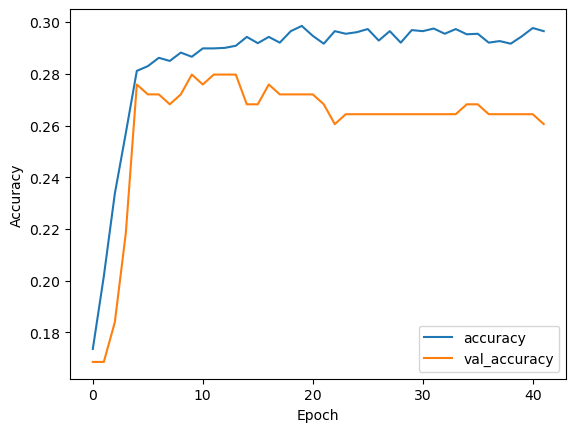

In [68]:
plt.plot(history_t_sgd.history['accuracy'], label='accuracy')
plt.plot(history_t_sgd.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

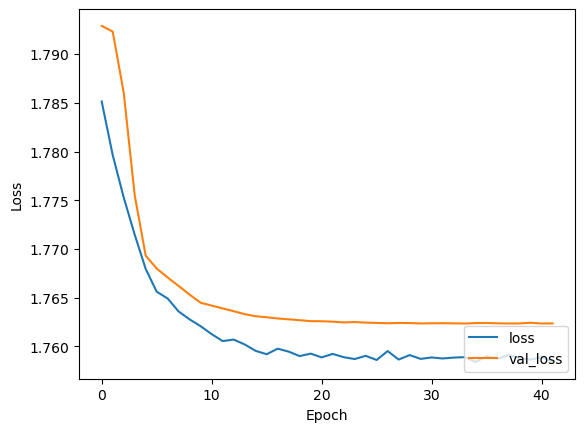

In [70]:
plt.plot(history_t_sgd.history['loss'], label='loss')
plt.plot(history_t_sgd.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

_Without Augmentation (With Adam optimizer)_

In [71]:
model_t_adam = model_1d((X_t_train.shape[1], 1))

# Model compilation
model_t_adam.compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model_t_adam.summary()

c:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 864, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 864, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 864, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 216, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 216, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 216, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 216, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 54, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 54, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 54, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 54, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 13, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 13, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 13, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 13, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 3, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 3, 64)          │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ seq_self_attention_1            │ (None, 3, 64)          │         4,161 │
│ (SeqSelfAttention)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 175,111 (684.03 KB)

 Trainable params: 174,343 (681.03 KB)

 Non-trainable params: 768 (3.00 KB)

In [72]:
history_t_adam = model_t_adam.fit(X_t_train,
                    y_train,
                    batch_size=16,
                    epochs=300,
                    validation_data=(X_t_val, y_val),
                    callbacks=[
                        es, 
                        ModelCheckpoint('model_t_adam.keras', monitor='val_loss', save_best_only=True, verbose=1),
                        lrs
                    ]
                   )

Epoch 1/300
310/310 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.2573 - loss: 1.7400
Epoch 1: val_loss improved from inf to 1.92806, saving model to model_t_adam.keras
310/310 ━━━━━━━━━━━━━━━━━━━━ 30s 74ms/step - accuracy: 0.2574 - loss: 1.7398 - val_accuracy: 0.1686 - val_loss: 1.9281 - learning_rate: 1.0000e-04
Epoch 2/300
309/310 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.3629 - loss: 1.5387
Epoch 2: val_loss improved from 1.92806 to 1.79654, saving model to model_t_adam.keras
310/310 ━━━━━━━━━━━━━━━━━━━━ 21s 68ms/step - accuracy: 0.3630 - loss: 1.5385 - val_accuracy: 0.2146 - val_loss: 1.7965 - learning_rate: 1.0000e-04
Epoch 3/300
309/310 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.4021 - loss: 1.4634
Epoch 3: val_loss improved from 1.79654 to 1.53803, saving model to model_t_adam.keras
310/310 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - accuracy: 0.4021 - loss: 1.4632 - val_accuracy: 0.3525 - val_loss: 1.5380 - learning_rate: 1.0000e-04
Epoch 4/300
309/310 ━━━━━━━━━━━━━━━━━━

In [73]:
test_loss_t_adam, test_acc_t_adam = model_t_adam.evaluate(X_t_test, y_test)

70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.4602 - loss: 1.3843


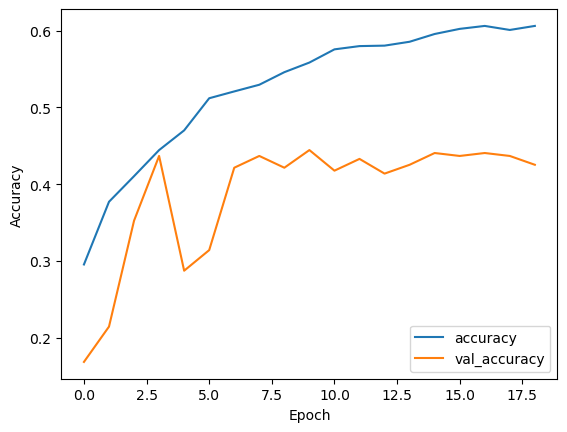

In [74]:
plt.plot(history_t_adam.history['accuracy'], label='accuracy')
plt.plot(history_t_adam.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

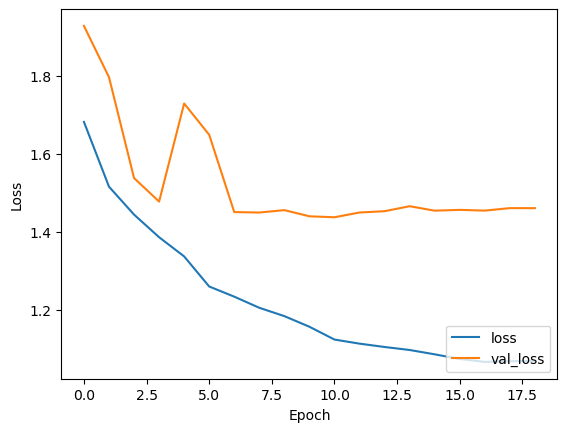

In [75]:
plt.plot(history_t_adam.history['loss'], label='loss')
plt.plot(history_t_adam.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

_With Augementation (with SGD optimizer)_

In [76]:
model_aug_t_sgd = model_1d((X_aug_t_train.shape[1], 1))

# Model compilation
model_aug_t_sgd.compile(optimizer=optimizers.SGD(learning_rate=0.0003, decay=1e-6, momentum=0.9, nesterov=True), loss='categorical_crossentropy', metrics=['accuracy'])
model_aug_t_sgd.summary()

c:\Users\Admin\anaconda3\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_8 (Conv1D)               │ (None, 864, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 864, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 864, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 216, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 216, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 216, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 216, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 54, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 54, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 54, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 54, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 13, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 13, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 13, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 13, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 3, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 3, 64)          │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ seq_self_attention_2            │ (None, 3, 64)          │         4,161 │
│ (SeqSelfAttention)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 175,111 (684.03 KB)

 Trainable params: 174,343 (681.03 KB)

 Non-trainable params: 768 (3.00 KB)

In [77]:
history_aug_t_sgd = model_aug_t_sgd.fit(X_aug_t_train,
                      y_aug_train,
                      batch_size=32,
                      epochs=200,
                      validation_data=(X_t_val, y_val),
                      callbacks=[
                          es,
                          ModelCheckpoint('model_aug_t_sgd.keras', monitor='val_loss', save_best_only=True, verbose=1),
                          lrs
                      ]
                     )

Epoch 1/200
464/464 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.2243 - loss: 1.7788
Epoch 1: val_loss improved from inf to 1.78454, saving model to model_aug_t_sgd.keras
464/464 ━━━━━━━━━━━━━━━━━━━━ 49s 94ms/step - accuracy: 0.2243 - loss: 1.7787 - val_accuracy: 0.1226 - val_loss: 1.7845 - learning_rate: 3.0000e-04
Epoch 2/200
464/464 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.2640 - loss: 1.7541
Epoch 2: val_loss improved from 1.78454 to 1.74205, saving model to model_aug_t_sgd.keras
464/464 ━━━━━━━━━━━━━━━━━━━━ 40s 85ms/step - accuracy: 0.2640 - loss: 1.7541 - val_accuracy: 0.2414 - val_loss: 1.7421 - learning_rate: 3.0000e-04
Epoch 3/200
464/464 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.2631 - loss: 1.7388
Epoch 3: val_loss improved from 1.74205 to 1.72771, saving model to model_aug_t_sgd.keras
464/464 ━━━━━━━━━━━━━━━━━━━━ 40s 85ms/step - accuracy: 0.2631 - loss: 1.7388 - val_accuracy: 0.2414 - val_loss: 1.7277 - learning_rate: 3.0000e-04
Epoch 4/200
464/464 ━━━━━━━━━

In [79]:
test_loss_aug_t_sgd, test_acc_aug_t_sgd = model_aug_t_sgd.evaluate(X_t_test, y_test)

70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.1833 - loss: 1.7842


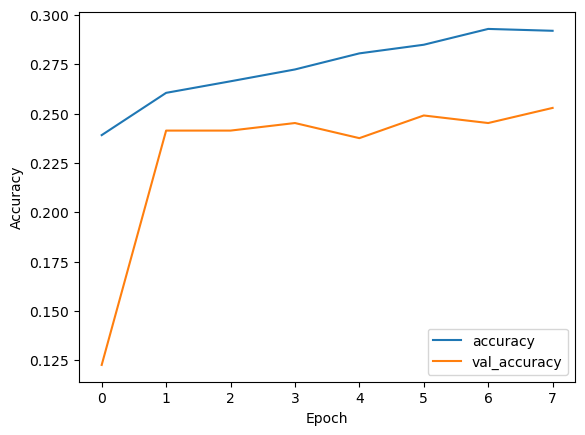

In [80]:
plt.plot(history_aug_t_sgd.history['accuracy'], label='accuracy')
plt.plot(history_aug_t_sgd.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

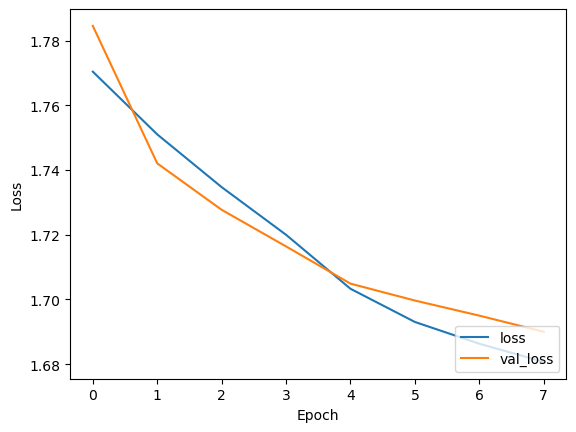

In [81]:
plt.plot(history_aug_t_sgd.history['loss'], label='loss')
plt.plot(history_aug_t_sgd.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

_With Augmentation (with Adam optimizer)_

In [82]:
model_aug_t_adam = model_1d((X_aug_t_train.shape[1], 1))

# Model compilation
model_aug_t_adam.compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model_aug_t_adam.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_12 (Conv1D)              │ (None, 864, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 864, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 864, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_12 (MaxPooling1D) │ (None, 216, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 216, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 216, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 216, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_13 (MaxPooling1D) │ (None, 54, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 54, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 54, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 54, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_14 (MaxPooling1D) │ (None, 13, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_15 (Conv1D)              │ (None, 13, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 13, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 13, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_15 (MaxPooling1D) │ (None, 3, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 3, 64)          │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ seq_self_attention_3            │ (None, 3, 64)          │         4,161 │
│ (SeqSelfAttention)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 175,111 (684.03 KB)

 Trainable params: 174,343 (681.03 KB)

 Non-trainable params: 768 (3.00 KB)

In [83]:
history_aug_t_adam = model_aug_t_adam.fit(
    X_aug_t_train,
    y_aug_train,
    batch_size=32,
    epochs=200,
    validation_data=(X_t_val, y_val),
    callbacks=[
        es,
        ModelCheckpoint('model_aug_t_adam.keras', monitor='val_loss', save_best_only=True, verbose=1),
        lrs
    ]
)

Epoch 1/200
464/464 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.2634 - loss: 1.7119
Epoch 1: val_loss improved from inf to 1.95081, saving model to model_aug_t_adam.keras
464/464 ━━━━━━━━━━━━━━━━━━━━ 57s 108ms/step - accuracy: 0.2634 - loss: 1.7118 - val_accuracy: 0.1762 - val_loss: 1.9508 - learning_rate: 1.0000e-04
Epoch 2/200
464/464 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.3633 - loss: 1.5205
Epoch 2: val_loss improved from 1.95081 to 1.54181, saving model to model_aug_t_adam.keras
464/464 ━━━━━━━━━━━━━━━━━━━━ 47s 102ms/step - accuracy: 0.3634 - loss: 1.5205 - val_accuracy: 0.3755 - val_loss: 1.5418 - learning_rate: 1.0000e-04
Epoch 3/200
464/464 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.3957 - loss: 1.4677
Epoch 3: val_loss did not improve from 1.54181
464/464 ━━━━━━━━━━━━━━━━━━━━ 47s 101ms/step - accuracy: 0.3957 - loss: 1.4677 - val_accuracy: 0.2797 - val_loss: 1.7036 - learning_rate: 1.0000e-04
Epoch 4/200
464/464 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accurac

In [84]:
test_loss_aug_t_adam, test_acc_aug_t_adam = model_aug_t_adam.evaluate(X_t_test, y_test)

70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.4819 - loss: 1.3373


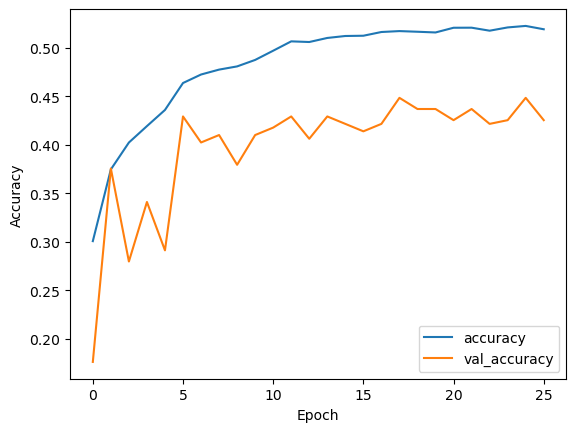

In [85]:
plt.plot(history_aug_t_adam.history['accuracy'], label='accuracy')
plt.plot(history_aug_t_adam.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

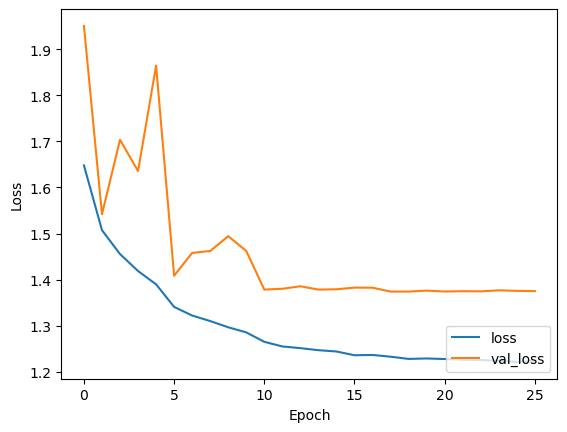

In [86]:
plt.plot(history_aug_t_adam.history['loss'], label='loss')
plt.plot(history_aug_t_adam.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

### Frequency Domain

In [42]:
def model_2d(input_shape):
    # Define the model architecture
    model = tf.keras.Sequential()
    
    # Add the layers
    # LFLB1
    model.add(layers.Conv2D(64, (3, 3), strides=(1,1), padding='same', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('elu'))
    model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    
    # LFLB2
    model.add(layers.Conv2D(64, (3, 3), strides=(1,1), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('elu'))
    model.add(layers.MaxPooling2D(pool_size=(4,4), strides=(4,4)))
    
    # LFLB3
    model.add(layers.Conv2D(128, (3, 3), strides=(1,1), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('elu'))
    model.add(layers.MaxPooling2D(pool_size=(4,4), strides=(4,4)))
    
    # LFLB4
    model.add(layers.Conv2D(128, (3, 3), strides=(1,1), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('elu'))
    model.add(layers.MaxPooling2D(pool_size=(4,4), strides=(4,4)))
    
    #LSTM
    model.add(layers.TimeDistributed(Flatten()))
    model.add(LSTM(units=64, return_sequences=True))
    model.add(SeqSelfAttention(attention_activation='tanh'))
    model.add(LSTM(units=64, return_sequences=False))
    
    #FC
    model.add(Dense(units=5, activation='softmax'))

    return model

_Without Augmentation_

In [43]:
model_f = model_2d((128, 128, 1))

model_f.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model_f.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 4, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 1, 128)         │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 1, 64)          │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ seq_self_attention_1            │ (None, 1, 64)          │         4,161 │
│ (SeqSelfAttention)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 347,462 (1.33 MB)

 Trainable params: 346,694 (1.32 MB)

 Non-trainable params: 768 (3.00 KB)

In [44]:
history_f = model_f.fit(X_f_train,
                      y_train,
                      batch_size=16,
                      epochs=20,
                      validation_data=(X_f_val, y_val),
                      callbacks=[
                          es,
                          ModelCheckpoint('model_f.keras', monitor='val_loss', save_best_only=True, verbose=1),
                          lrs
                      ]
)

Epoch 1/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.3828 - loss: 1.5562
Epoch 1: val_loss improved from inf to 1.54526, saving model to model_f.keras
103/103 ━━━━━━━━━━━━━━━━━━━━ 44s 347ms/step - accuracy: 0.3834 - loss: 1.5557 - val_accuracy: 0.3333 - val_loss: 1.5453 - learning_rate: 1.0000e-04
Epoch 2/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.5826 - loss: 1.3213
Epoch 2: val_loss improved from 1.54526 to 1.31123, saving model to model_f.keras
103/103 ━━━━━━━━━━━━━━━━━━━━ 34s 334ms/step - accuracy: 0.5828 - loss: 1.3207 - val_accuracy: 0.4713 - val_loss: 1.3112 - learning_rate: 1.0000e-04
Epoch 3/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.7240 - loss: 1.0301
Epoch 3: val_loss improved from 1.31123 to 1.02122, saving model to model_f.keras
103/103 ━━━━━━━━━━━━━━━━━━━━ 35s 335ms/step - accuracy: 0.7242 - loss: 1.0296 - val_accuracy: 0.5977 - val_loss: 1.0212 - learning_rate: 1.0000e-04
Epoch 4/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/s

In [45]:
test_loss_f, test_acc_f = model_f.evaluate(X_f_test, y_test)

24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 0.9079 - loss: 0.3296


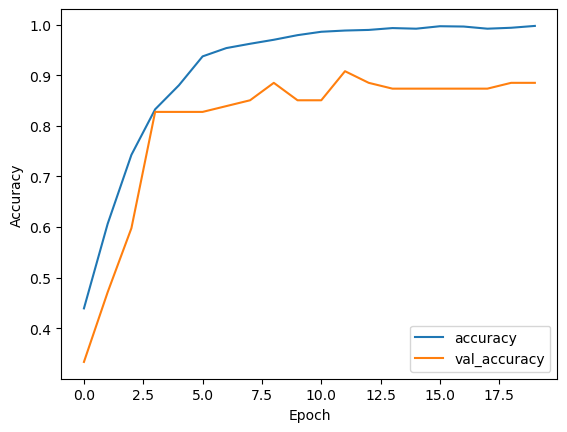

In [46]:
plt.plot(history_f.history['accuracy'], label='accuracy')
plt.plot(history_f.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

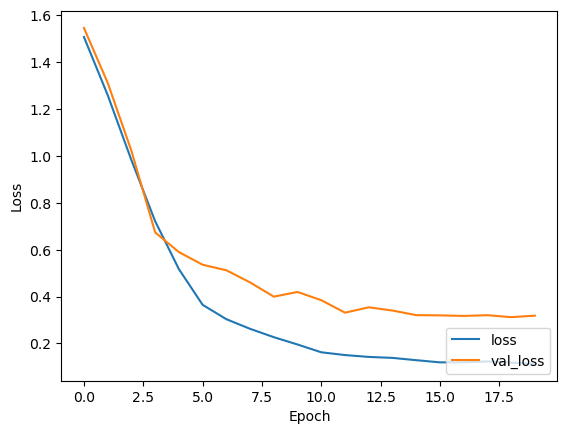

In [47]:
plt.plot(history_f.history['loss'], label='loss')
plt.plot(history_f.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

_With Augmentation_

In [48]:
model_aug_f = model_2d((128, 128, 1))
model_aug_f.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model_aug_f.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 128, 128, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 4, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 1, 128)         │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 1, 64)          │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ seq_self_attention_2            │ (None, 1, 64)          │         4,161 │
│ (SeqSelfAttention)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 347,462 (1.33 MB)

 Trainable params: 346,694 (1.32 MB)

 Non-trainable params: 768 (3.00 KB)

In [49]:
history_aug_f = model_aug_f.fit(
    X_aug_f_train,
    y_aug_train,
    batch_size=16,
    epochs=20,
    verbose=1,
    validation_data=(X_f_val, y_val),
    callbacks=[
        es,
        ModelCheckpoint('model_aug_f.keras', monitor='val_loss', save_best_only=True, verbose=1),
        lrs
    ]
)

Epoch 1/20
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.3714 - loss: 1.5300
Epoch 1: val_loss improved from inf to 1.07492, saving model to model_aug_f.keras
309/309 ━━━━━━━━━━━━━━━━━━━━ 106s 315ms/step - accuracy: 0.3717 - loss: 1.5296 - val_accuracy: 0.5862 - val_loss: 1.0749 - learning_rate: 1.0000e-04
Epoch 2/20
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.6683 - loss: 1.0049
Epoch 2: val_loss improved from 1.07492 to 0.59775, saving model to model_aug_f.keras
309/309 ━━━━━━━━━━━━━━━━━━━━ 97s 313ms/step - accuracy: 0.6685 - loss: 1.0045 - val_accuracy: 0.7931 - val_loss: 0.5977 - learning_rate: 1.0000e-04
Epoch 3/20
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.7979 - loss: 0.6333
Epoch 3: val_loss did not improve from 0.59775
309/309 ━━━━━━━━━━━━━━━━━━━━ 96s 310ms/step - accuracy: 0.7979 - loss: 0.6332 - val_accuracy: 0.6207 - val_loss: 0.9351 - learning_rate: 1.0000e-04
Epoch 4/20
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 0.8591 - l

In [50]:
test_loss_aug_f, test_acc_aug_f = model_aug_f.evaluate(X_f_test, y_test)

24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.9162 - loss: 0.2461


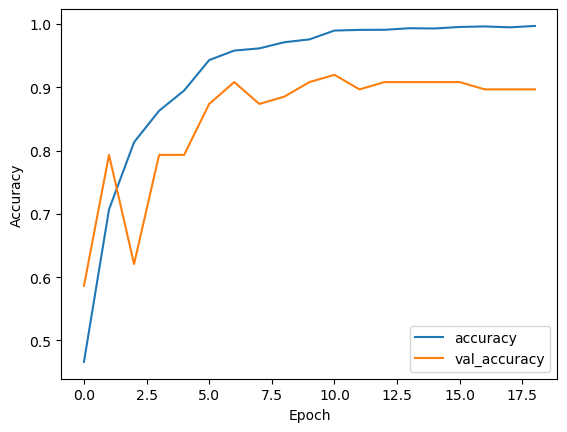

In [51]:
plt.plot(history_aug_f.history['accuracy'], label='accuracy')
plt.plot(history_aug_f.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

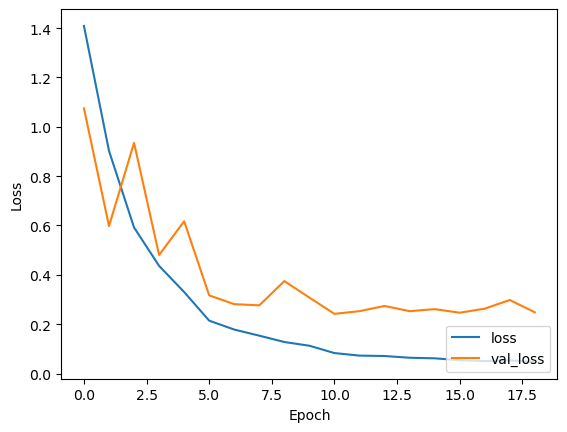

In [52]:
plt.plot(history_aug_f.history['loss'], label='loss')
plt.plot(history_aug_f.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

In [58]:
def compare_performance(y_true, y_pred):
    y_true = np.argmax(y_true, axis=1)
    y_pred = np.argmax(y_pred, axis=1)
    
    matrix = confusion_matrix(y_true, y_pred)
    ax = sns.heatmap(matrix, annot=True, fmt="d", cmap='rocket_r', xticklabels=['Anger', 'Fear', 'Happiness', 'Neutral', 'Sadness'], yticklabels=['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness'])
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    
    print(classification_report(y_true, y_pred))

### Time Domain

**_Without Augmentation_**

In [99]:
y_train_pred_t = model_t_adam.predict(X_t_train)
y_val_pred_t = model_t_adam.predict(X_t_val)
y_test_pred_t = model_t_adam.predict(X_t_test)

155/155 ━━━━━━━━━━━━━━━━━━━━ 19s 107ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step


**Training**

              precision    recall  f1-score   support

           0       0.78      0.80      0.79       845
           1       0.61      0.50      0.55       845
           2       0.54      0.40      0.46       845
           3       0.56      0.61      0.59       845
           4       0.52      0.62      0.57       723
           5       0.59      0.68      0.63       845

    accuracy                           0.60      4948
   macro avg       0.60      0.60      0.60      4948
weighted avg       0.60      0.60      0.60      4948



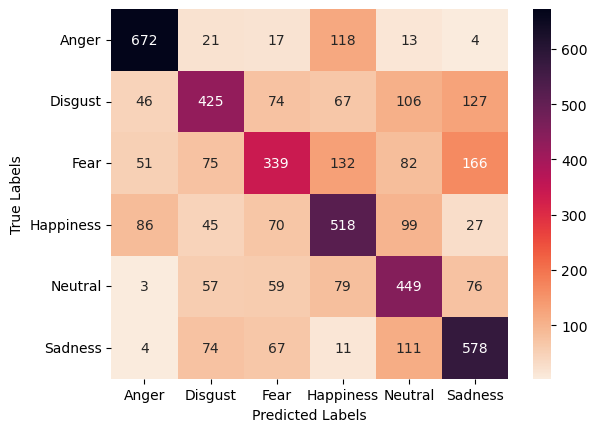

In [100]:
compare_performance(y_train, y_train_pred_t)

**Validation**

              precision    recall  f1-score   support

           0       0.62      0.69      0.65        45
           1       0.30      0.23      0.26        44
           2       0.34      0.24      0.29        45
           3       0.31      0.38      0.34        45
           4       0.39      0.45      0.41        38
           5       0.49      0.52      0.51        44

    accuracy                           0.42       261
   macro avg       0.41      0.42      0.41       261
weighted avg       0.41      0.42      0.41       261



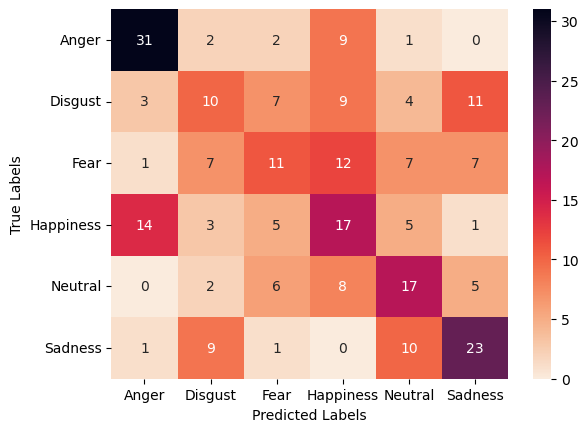

In [101]:
compare_performance(y_val, y_val_pred_t)

**Test**

              precision    recall  f1-score   support

           0       0.62      0.62      0.62       381
           1       0.43      0.38      0.41       382
           2       0.29      0.19      0.23       381
           3       0.39      0.46      0.42       381
           4       0.41      0.48      0.44       326
           5       0.51      0.57      0.54       382

    accuracy                           0.45      2233
   macro avg       0.44      0.45      0.44      2233
weighted avg       0.44      0.45      0.44      2233



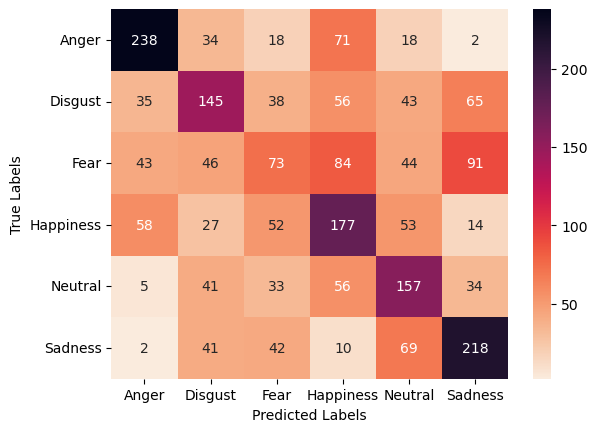

In [102]:
compare_performance(y_test, y_test_pred_t)

**_With Augmentation_**

In [103]:
y_train_pred_aug_t = model_aug_t_adam.predict(X_aug_t_train)
y_val_pred_aug_t = model_aug_t_adam.predict(X_t_val)
y_test_pred_aug_t = model_aug_t_adam.predict(X_t_test)

464/464 ━━━━━━━━━━━━━━━━━━━━ 42s 86ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step


**Training**

              precision    recall  f1-score   support

           0       0.70      0.74      0.72      2535
           1       0.50      0.39      0.44      2535
           2       0.44      0.28      0.35      2535
           3       0.52      0.49      0.50      2535
           4       0.51      0.55      0.53      2169
           5       0.47      0.70      0.56      2535

    accuracy                           0.53     14844
   macro avg       0.52      0.53      0.52     14844
weighted avg       0.52      0.53      0.52     14844



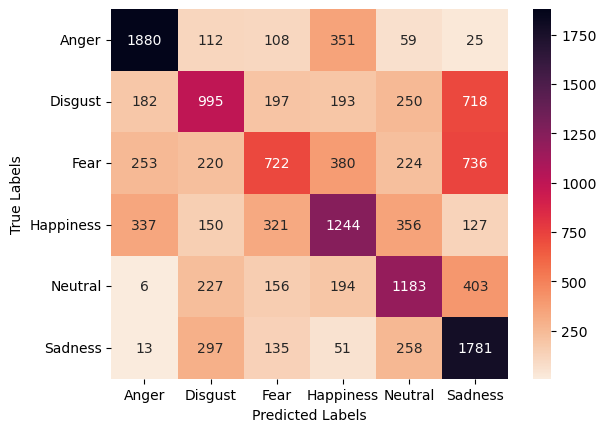

In [104]:
compare_performance(y_aug_train, y_train_pred_aug_t)

**Validation**

              precision    recall  f1-score   support

           0       0.59      0.64      0.62        45
           1       0.37      0.25      0.30        44
           2       0.42      0.31      0.36        45
           3       0.37      0.38      0.37        45
           4       0.39      0.42      0.41        38
           5       0.48      0.68      0.57        44

    accuracy                           0.45       261
   macro avg       0.44      0.45      0.44       261
weighted avg       0.44      0.45      0.44       261



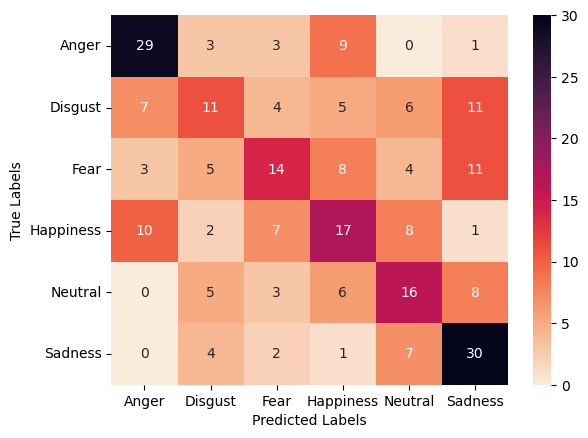

In [105]:
compare_performance(y_val, y_val_pred_aug_t)

**Test**

              precision    recall  f1-score   support

           0       0.62      0.66      0.64       381
           1       0.46      0.36      0.40       382
           2       0.31      0.20      0.24       381
           3       0.43      0.44      0.43       381
           4       0.42      0.46      0.44       326
           5       0.48      0.69      0.57       382

    accuracy                           0.47      2233
   macro avg       0.45      0.47      0.45      2233
weighted avg       0.46      0.47      0.45      2233



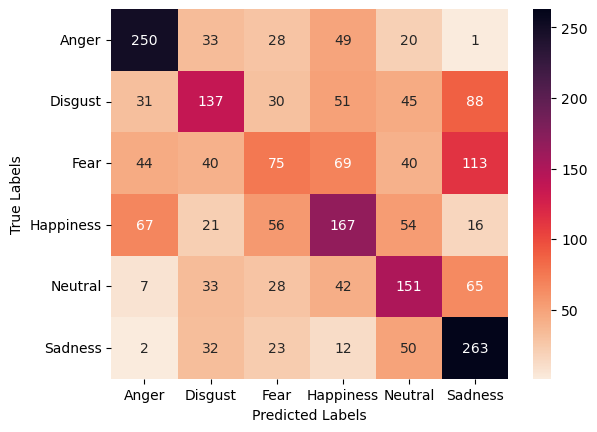

In [106]:
compare_performance(y_test, y_test_pred_aug_t)

### Frequency Domain

**_Without Augmentation_**

In [59]:
y_train_pred_f = model_f.predict(X_f_train)
y_val_pred_f = model_f.predict(X_f_val)
y_test_pred_f = model_f.predict(X_f_test)

52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step


**Training**

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       323
           1       1.00      1.00      1.00       339
           2       1.00      1.00      1.00       323
           3       1.00      1.00      1.00       347
           4       1.00      1.00      1.00       312

    accuracy                           1.00      1644
   macro avg       1.00      1.00      1.00      1644
weighted avg       1.00      1.00      1.00      1644



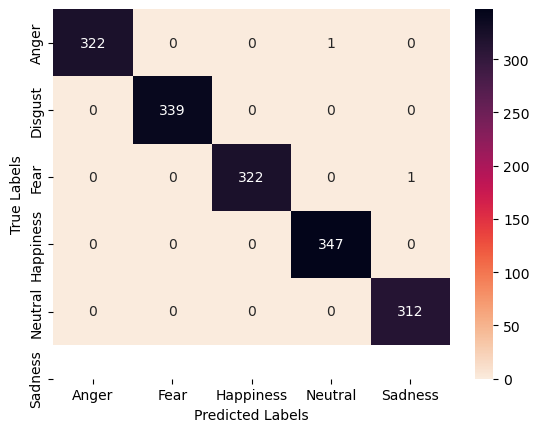

In [60]:
compare_performance(y_train, y_train_pred_f)

**Validation**

              precision    recall  f1-score   support

           0       0.94      0.88      0.91        17
           1       1.00      0.78      0.88        18
           2       0.88      0.88      0.88        17
           3       0.81      0.94      0.87        18
           4       0.84      0.94      0.89        17

    accuracy                           0.89        87
   macro avg       0.89      0.89      0.89        87
weighted avg       0.89      0.89      0.89        87



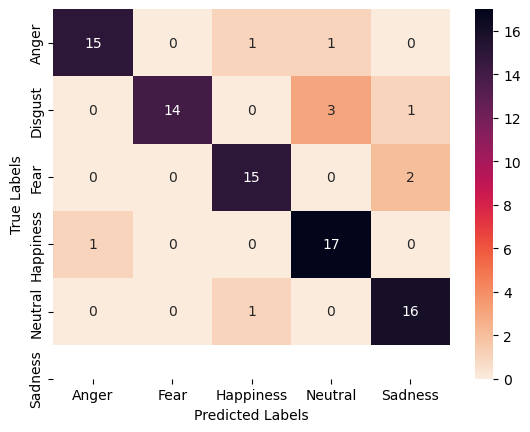

In [61]:
compare_performance(y_val, y_val_pred_f)

**Test**

              precision    recall  f1-score   support

           0       0.95      0.92      0.94       146
           1       0.90      0.90      0.90       153
           2       0.92      0.82      0.87       146
           3       0.90      0.96      0.93       157
           4       0.87      0.93      0.90       141

    accuracy                           0.91       743
   macro avg       0.91      0.91      0.91       743
weighted avg       0.91      0.91      0.91       743



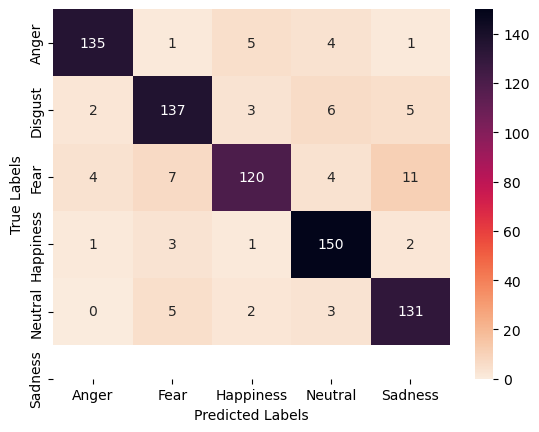

In [62]:
compare_performance(y_test, y_test_pred_f)

**_With Augmentation_**

In [63]:
y_train_pred_aug_f = model_aug_f.predict(X_aug_f_train)
y_val_pred_aug_f = model_aug_f.predict(X_f_val)
y_test_pred_aug_f = model_aug_f.predict(X_f_test)

155/155 ━━━━━━━━━━━━━━━━━━━━ 18s 115ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step


**Training**

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       969
           1       1.00      0.99      0.99      1017
           2       1.00      1.00      1.00       969
           3       0.99      1.00      1.00      1041
           4       0.99      1.00      0.99       936

    accuracy                           1.00      4932
   macro avg       1.00      1.00      1.00      4932
weighted avg       1.00      1.00      1.00      4932



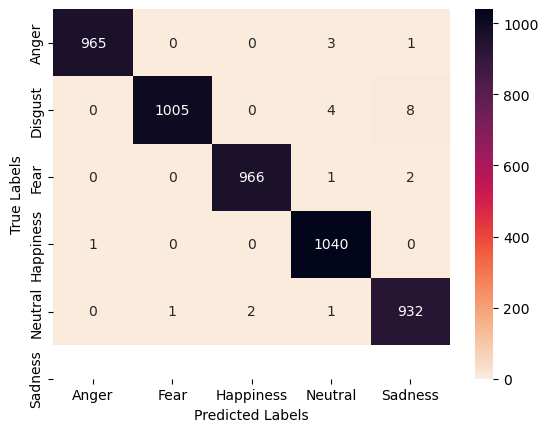

In [64]:
compare_performance(y_aug_train, y_train_pred_aug_f)

**Validation**

              precision    recall  f1-score   support

           0       0.89      0.94      0.91        17
           1       0.94      0.94      0.94        18
           2       0.94      0.88      0.91        17
           3       0.89      0.89      0.89        18
           4       0.94      0.94      0.94        17

    accuracy                           0.92        87
   macro avg       0.92      0.92      0.92        87
weighted avg       0.92      0.92      0.92        87



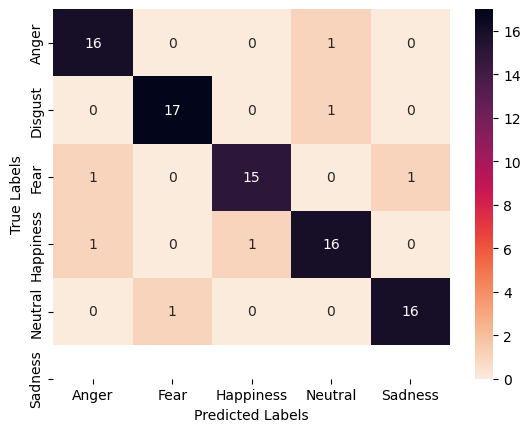

In [65]:
compare_performance(y_val, y_val_pred_aug_f)

**Test**

              precision    recall  f1-score   support

           0       0.95      0.92      0.94       146
           1       0.91      0.90      0.90       153
           2       0.92      0.86      0.89       146
           3       0.90      0.96      0.93       157
           4       0.88      0.92      0.90       141

    accuracy                           0.91       743
   macro avg       0.91      0.91      0.91       743
weighted avg       0.91      0.91      0.91       743



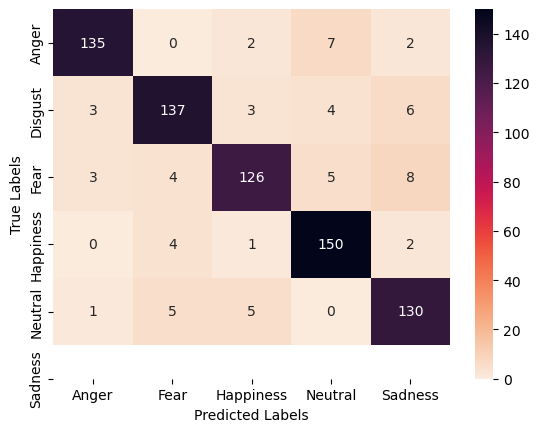

In [66]:
compare_performance(y_test, y_test_pred_aug_f)